In [186]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



## Cargamos dataset

In [187]:
# Cargamos dataset Breast Cancer Wisconsin (Original)
ds = pd.read_csv('./breast-cancer-wisconsin.data', usecols=[1,2,3,4,5,6,7,8,9,10], 
                 names=[0,1,2,3,4,5,6,7,8,9], header=None)

In [188]:
output = 9
# Transformamos la columna de clases a 0-1 (actualmente son 2,4)
ds[output] = np.uint8(ds[output]/2-1)
y = ds[output].values
X = ds.drop(output,axis=1).values
seed = 42
random.seed(seed)
np.random.seed(seed)

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Según https://archive.ics.uci.edu/ml/datasets, los Missing Values están etiquetados como '?'.  
Eliminamos las filas con dicho valor.

In [189]:
rows = np.argwhere(X == '?')[:,0]
X = np.delete(X,rows,0)
y = np.delete(y,rows)
X = X.astype(np.uint8)

In [190]:
attr = []
# Iteramos los atributos del dataset
for i in ds.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(ds[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [191]:
ds.columns.drop(output)[ds.std() < 0.001]

Int64Index([], dtype='int64')

**Comprobamos que no haya variables iguales**  
Vemos que no hay ninguna.

In [192]:
resultados = np.zeros((len(ds.columns), len(ds.columns)))
for i in range(len(ds.columns)):
    for j in range(len(ds.columns)):
        resultados[i, j] = np.mean(ds.iloc[:, i] == ds.iloc[:, j])

In [193]:
iguales = []
for i, j in it.combinations(range(len(ds.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(ds.columns[i])
        print(ds.columns[i], ds.columns[j])

**Comprobamos que las clases no estén desbalanceadas**  
Están un poco desbalanceadas.

In [194]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))

Proporción clase 0:  0.6500732064421669
Proporción clase 1:  0.34992679355783307


**Desordenamos los datos**

In [195]:
X,y = shuffle(X,y)

## Entrenamiento de Modelos

**kFold - Decision Tree Classifier**

In [196]:
kf = KFold(n_splits=10,shuffle=True)
resultados_train = []
resultados_valid = []
model = []
res_train = np.empty((30,0))
res_valid = np.empty((30,0))
test_indices = []
etiquetas = ['DT Normal',
             'DT Profundidad',
             'DT Minimo de muestras por hoja',
             'DT Minimo de muestras en subarbol',
             'DT Minimo de impureza',
             'LDA lsqr',
             'LDA eigen',
             'LDA svd',
             'QDA']
dicc = [{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': 5,    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.2}]

for i in range(len(dicc)):
    test_indices2 = []
    for j in range(3):
        for train_index, test_index in kf.split(X):
    #         train_test_split del conjunto train y pillar 1/9 para validación
            X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
            test_indices2.append(test_index)
    #         print('X_train: {}\n, X_valid: {}\n, X_test: {}'.format(X_train, X_valid, X_test))
            alg = DecisionTreeClassifier(**dicc[i])
            alg.fit(X_train, y_train)
            model.append(alg)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_valid.append(alg.score(X_valid, y_valid))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_valid = np.hstack((res_valid, np.array(resultados_valid,ndmin=2).T))
    resultados_train = []
    resultados_valid = []
    test_indices.append(test_indices2)

    
            

**kFold - Linear Discriminant Analysis**

In [197]:
for tipo in ('lsqr', 'eigen', 'svd'):
    test_indices2 = []
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
            alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
            test_indices2.append(test_index)
            alg.fit(X_train, y_train)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_valid.append(alg.score(X_valid, y_valid))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_valid = np.hstack((res_valid, np.array(resultados_valid,ndmin=2).T))
    resultados_train = []
    resultados_valid = []
    test_indices.append(test_indices2)

**kFold - Quadratic Discriminant Analysis**

In [198]:

test_indices2 = []
for _ in range(3):
    for train_index, test_index in kf.split(X):
        X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
        test_indices2.append(test_index)
        alg = QuadraticDiscriminantAnalysis()
        alg.fit(X_train, y_train)
        resultados_train.append(alg.score(X_train, y_train))
        resultados_valid.append(alg.score(X_valid, y_valid))
res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
res_valid = np.hstack((res_valid, np.array(resultados_valid,ndmin=2).T))
resultados_train = []
resultados_valid = []
test_indices.append(test_indices2)


**kFold - Support Vector Classification**

In [199]:
# kf = KFold(n_splits=10,shuffle=True)
# res_train = np.empty((30,0))
# res_valid = np.empty((30,0))
# test_indices = []
etiquetas.extend(['SVM linear C1',
             'SVM poly 2º C1',
             'SVM poly 3º C1',
             'SVM poly 4º C1',
             'SVM rfb auto C1',
             'SVM rfb 0.05 C1',
             'SVM rfb 0.1 C1',
             'SVM rfb 0.2 C1'])
etiquetas.extend(['SVM linear C100',
             'SVM poly 2º C100',
             'SVM poly 3º C100',
             'SVM poly 4º C100',
             'SVM rfb auto C100',
             'SVM rfb 0.05 C100',
             'SVM rfb 0.1 C100',
             'SVM rfb 0.2 C100'])
etiquetas.extend(['SVM linear C1000',
             'SVM poly 2º C1000',
             'SVM poly 3º C1000',
             'SVM poly 4º C1000',
             'SVM rfb auto C1000',
             'SVM rfb 0.05 C1000',
             'SVM rfb 0.1 C1000',
             'SVM rfb 0.2 C1000'])
dicc = [{'C': 1.0, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'},
        {'C': 1.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'},
        {'C': 1.0, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'},
        {'C': 1.0, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto'},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.1},
        {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.2},
        {'C': 100.0, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'},
        {'C': 100.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'},
        {'C': 100.0, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'},
        {'C': 100.0, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'},
        {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto'},
        {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05},
        {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.1},
        {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.2},
        {'C': 1000.0, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'},
        {'C': 1000.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'},
        {'C': 1000.0, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'},
        {'C': 1000.0, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'},
        {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto'},
        {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05},
        {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.1},
        {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.2}]

for i in range(len(dicc)):
    test_indices2 = []
    for j in range(3):
        for train_index, test_index in kf.split(X):
    #         train_test_split del conjunto train y pillar 1/9 para validación
            X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
            test_indices2.append(test_index)
    #         print('X_train: {}\n, X_valid: {}\n, X_test: {}'.format(X_train, X_valid, X_test))
            alg = SVC(**dicc[i])
            alg.fit(X_train, y_train)
            model.append(alg)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_valid.append(alg.score(X_valid, y_valid))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_valid = np.hstack((res_valid, np.array(resultados_valid,ndmin=2).T))
    resultados_train = []
    resultados_valid = []
    test_indices.append(test_indices2)

**Test de normalidad**  
Rechazamos normalidad, podriamos asumir normalidad en alguno de ellos pero como en algunos no, realizamos el test no paramétrico de Kruskal-Wallis en lugar de un Anova 

In [200]:
np.apply_along_axis(lambda x: stats.shapiro(x)[1], axis=0, arr=res_valid)


array([8.53491798e-02, 1.96003079e-01, 8.02860111e-02, 2.97894359e-01,
       7.17464626e-01, 3.61306896e-03, 5.14273066e-04, 1.15977705e-01,
       1.65745944e-01, 2.23817639e-02, 4.16895635e-02, 1.16042599e-01,
       1.59264505e-01, 2.95169763e-02, 1.87424961e-02, 3.78326252e-02,
       1.60980016e-01, 1.29251638e-02, 2.48236835e-01, 2.52142102e-01,
       1.17922083e-01, 1.78050295e-01, 1.54845035e-02, 8.15578364e-03,
       9.32917148e-02, 2.49839062e-03, 4.52430220e-03, 5.98724127e-01,
       2.97513962e-01, 7.22023193e-03, 1.57393795e-02, 5.55503033e-02,
       8.03606138e-02])

**Test de Kruskal-Wallis**  
Rechazamos que las precisiones sean similares

In [201]:
print(stats.kruskal(*zip(*list(res_valid))))

KruskalResult(statistic=266.4624743015203, pvalue=8.758240139684885e-39)


In [202]:
labels = [etiquetas[i] for i in range(res_valid.shape[1]) for _ in range(res_valid.shape[0])]
arr_valid = res_valid.flatten('F')
resultados = pairwise_tukeyhsd(arr_valid,labels)
# resultados.summary()

In [203]:
#seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
best_group = np.argmax(np.mean(res_valid, axis = 0))
best_group = etiquetas[int(best_group)]

Figure(720x432)


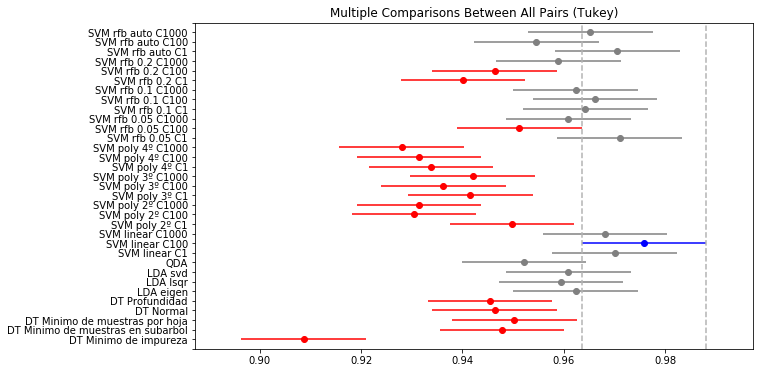

In [204]:
print(resultados.plot_simultaneous(comparison_name=best_group))

In [205]:
resultados = resultados._results_table.data

In [206]:
group1 = resultados[0].index('group1')
group2 = resultados[0].index('group2')
reject = resultados[0].index('reject')
best_groups = []
for row in resultados[1:]:
    if (row[group1] == str(best_group) or row[group2] == str(best_group)) and not row[reject]:
        best_groups.append(row[group1])
        best_groups.append(row[group2])
best_groups = set(best_groups)
sorted(best_groups)

['LDA eigen',
 'LDA lsqr',
 'LDA svd',
 'QDA',
 'SVM linear C1',
 'SVM linear C100',
 'SVM linear C1000',
 'SVM rfb 0.05 C1',
 'SVM rfb 0.05 C1000',
 'SVM rfb 0.1 C1',
 'SVM rfb 0.1 C100',
 'SVM rfb 0.1 C1000',
 'SVM rfb 0.2 C1000',
 'SVM rfb auto C1',
 'SVM rfb auto C100',
 'SVM rfb auto C1000']

**Nos quedamos con el más sencillo**  
El cual asumimos que es el Lineal Discriminant Analysis con lsqr (Minimos cuadrados)

In [207]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real == PositiveClass and predicted != PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [208]:
# Escogemos el modelo más simple de entre los mejores
simple = etiquetas.index('LDA svd')
tipo = 'svd'
Sens_l = []
Spec_l = []
PPV_l = []
NPV_l = []
ACC_l = []
for test_index in test_indices[simple]:
    train_index = np.ones(y.shape, dtype=bool)
    train_index[test_index] = False
    X_test, y_test = X[test_index], y[test_index]
    X_train, y_train = X[train_index], y[train_index]
    alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
    alg.fit(X_train, y_train)
    y_pred = alg.predict(X_test)
    CM = confusion_matrix(y_test, y_pred)
    Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
    Sens_l.append(Sens)
    Spec_l.append(Spec)
    PPV_l.append(PPV)
    NPV_l.append(NPV)
    ACC_l.append(ACC)
print(('Sens: {:.2f}, Spec: {:.2f}, ' +
       'PPV: {:.2f}, NPV: {:.2f}, ACC: {:.2f}').format(np.mean(Sens_l),
                                                       np.mean(Spec_l),
                                                       np.mean(PPV_l),
                                                       np.mean(NPV_l),
                                                       np.mean(ACC_l)))


Sens: 0.92, Spec: 0.98, PPV: 0.97, NPV: 0.96, ACC: 0.96


**----------------------------------------------------------------------------------------------------------------------------**

In [209]:
for ind, tag in enumerate(etiquetas):
    mean_val = np.mean(res_valid[:,ind])
    std_val = np.std(res_valid[:,ind])
    print('{}: {:.2f} +- {:.2f}'.format(tag, mean_val, std_val))

DT Normal: 0.95 +- 0.02
DT Profundidad: 0.95 +- 0.03
DT Minimo de muestras por hoja: 0.95 +- 0.03
DT Minimo de muestras en subarbol: 0.95 +- 0.03
DT Minimo de impureza: 0.91 +- 0.03
LDA lsqr: 0.96 +- 0.03
LDA eigen: 0.96 +- 0.02
LDA svd: 0.96 +- 0.02
QDA: 0.95 +- 0.02
SVM linear C1: 0.97 +- 0.02
SVM poly 2º C1: 0.95 +- 0.02
SVM poly 3º C1: 0.94 +- 0.03
SVM poly 4º C1: 0.93 +- 0.03
SVM rfb auto C1: 0.97 +- 0.02
SVM rfb 0.05 C1: 0.97 +- 0.02
SVM rfb 0.1 C1: 0.96 +- 0.02
SVM rfb 0.2 C1: 0.94 +- 0.03
SVM linear C100: 0.98 +- 0.02
SVM poly 2º C100: 0.93 +- 0.03
SVM poly 3º C100: 0.94 +- 0.03
SVM poly 4º C100: 0.93 +- 0.02
SVM rfb auto C100: 0.95 +- 0.02
SVM rfb 0.05 C100: 0.95 +- 0.03
SVM rfb 0.1 C100: 0.97 +- 0.02
SVM rfb 0.2 C100: 0.95 +- 0.02
SVM linear C1000: 0.97 +- 0.02
SVM poly 2º C1000: 0.93 +- 0.02
SVM poly 3º C1000: 0.94 +- 0.03
SVM poly 4º C1000: 0.93 +- 0.03
SVM rfb auto C1000: 0.97 +- 0.02
SVM rfb 0.05 C1000: 0.96 +- 0.02
SVM rfb 0.1 C1000: 0.96 +- 0.02
SVM rfb 0.2 C1000: 0.96 

## Persistencia

In [210]:
# with open('RForest_Zika_oversampled.bin','wb') as file:
#     pickle.dump(alg_o, file)
# with open('RForest_Zika_undersampled.bin','wb') as file:
#     pickle.dump(alg_u, file)

## FIN